# Bilingual Speech Recognition using MFCC and DTW
## Converting MATLAB Implementation to Python

This notebook implements a bilingual (Bangla and English) speech recognition system using:
- **MFCC (Mel-Frequency Cepstral Coefficients)** for feature extraction
- **DTW (Dynamic Time Warping)** for pattern matching with dynamic programming

The system performs **word-level recognition** as a first step towards complete sentence recognition.

### Project Structure:
- Audio preprocessing (mono conversion, normalization, silence trimming)
- MFCC feature extraction using librosa
- DTW distance calculation for template matching
- Template creation and storage
- Main recognition engine

## 1. Installation and Imports
Install required libraries and import necessary modules

In [1]:
# Install required packages
!pip install librosa numpy scipy matplotlib dtw-python soundfile pickle-mixin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.1/789.1 kB 48.2 MB/s eta 0:00:00
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5988 sha256=02bf98828c90612ead4299426d72c6d38e80ab9f83651022bf0722227fe65d6c
  Stored in directory: /root/.cache/pip/wheels/69/e2/5c/da8f96a08c63469bc8b10e206cd4c78e8886d8acb8699f84c2
Successfully built pickle-mixin


In [2]:
# Import necessary libraries
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.spatial.distance import cdist
from dtw import dtw
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"NumPy version: {np.__version__}")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

✅ All libraries imported successfully!
Librosa version: 0.11.0
NumPy version: 2.0.2


## 2. Audio Preprocessing Functions
Convert MATLAB preprocess_audio.m functionality to Python

In [3]:
def trim_silence(audio, sr, frame_length=0.02, energy_threshold=0.01):
    """
    Trim silence from the beginning and end of audio signal

    Parameters:
    audio: numpy array - input audio signal
    sr: int - sampling rate
    frame_length: float - frame length in seconds (default 0.02 = 20ms)
    energy_threshold: float - energy threshold ratio (default 0.01)

    Returns:
    trimmed_audio: numpy array - audio with silence trimmed
    """
    if len(audio) == 0:
        return audio

    # Frame size in samples
    win_length = int(frame_length * sr)

    # Calculate frame energy
    frame_energy = []
    for i in range(0, len(audio) - win_length + 1, win_length):
        frame = audio[i:i + win_length]
        energy = np.sum(frame ** 2)
        frame_energy.append(energy)

    if len(frame_energy) == 0:
        return audio

    frame_energy = np.array(frame_energy)
    threshold = energy_threshold * np.max(frame_energy)

    # Find voiced frames (above threshold)
    voiced_frames = np.where(frame_energy > threshold)[0]

    if len(voiced_frames) == 0:
        return audio

    # Calculate start and stop indices
    start_frame = max(0, voiced_frames[0] - 1)
    stop_frame = min(len(frame_energy) - 1, voiced_frames[-1])

    start_sample = max(0, start_frame * win_length)
    stop_sample = min(len(audio), (stop_frame + 1) * win_length)

    return audio[start_sample:stop_sample]


def preprocess_audio(audio, sr):
    """
    Preprocess audio signal: convert to mono, remove DC offset, normalize, trim silence

    Parameters:
    audio: numpy array - input audio signal
    sr: int - sampling rate

    Returns:
    processed_audio: numpy array - preprocessed audio signal
    """
    # Convert to mono if stereo
    if len(audio.shape) > 1 and audio.shape[1] == 2:
        audio = np.mean(audio, axis=1)

    # Remove DC offset (mean centering)
    audio = audio - np.mean(audio)

    # Normalize amplitude
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        audio = audio / max_val

    # Trim silence
    audio = trim_silence(audio, sr)

    return audio

print("✅ Audio preprocessing functions defined!")

✅ Audio preprocessing functions defined!


## 3. MFCC Feature Extraction
Convert MATLAB extract_mfcc.m functionality using librosa

In [4]:
def extract_mfcc(audio, sr, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=40):
    """
    Extract MFCC features from audio signal

    Parameters:
    audio: numpy array - input audio signal
    sr: int - sampling rate
    n_mfcc: int - number of MFCC coefficients (default 13)
    n_fft: int - FFT window size (default 2048)
    hop_length: int - hop length for STFT (default 512)
    n_mels: int - number of mel filter banks (default 40)

    Returns:
    mfcc_features: numpy array - MFCC features [n_frames x n_mfcc]
    """
    # Extract MFCC features using librosa
    mfcc_features = librosa.feature.mfcc(
        y=audio,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Transpose to match MATLAB format [n_frames x n_features]
    mfcc_features = mfcc_features.T

    return mfcc_features


def normalize_features(mfcc_features):
    """
    Normalize MFCC features using z-score normalization

    Parameters:
    mfcc_features: numpy array - input MFCC features [n_frames x n_features]

    Returns:
    normalized_features: numpy array - normalized MFCC features
    """
    # Calculate mean and standard deviation along time axis (axis=0)
    mu = np.mean(mfcc_features, axis=0)
    sigma = np.std(mfcc_features, axis=0) + np.finfo(float).eps  # Add small epsilon for numerical stability

    # Z-score normalization
    normalized_features = (mfcc_features - mu) / sigma

    return normalized_features

print("✅ MFCC extraction and normalization functions defined!")

✅ MFCC extraction and normalization functions defined!


## 4. Dynamic Time Warping (DTW) Implementation
Convert MATLAB dtw_distance.m with dynamic programming approach

In [5]:
def dtw_distance(mfcc1, mfcc2, distance_metric='euclidean'):
    """
    Calculate DTW distance between two MFCC feature sequences using dynamic programming

    Parameters:
    mfcc1: numpy array - first MFCC sequence [n_frames1 x n_features]
    mfcc2: numpy array - second MFCC sequence [n_frames2 x n_features]
    distance_metric: str - distance metric to use (default 'euclidean')

    Returns:
    dtw_dist: float - DTW distance between the two sequences
    """
    # Calculate pairwise distance matrix
    D = cdist(mfcc1, mfcc2, metric=distance_metric)

    n, m = D.shape

    # Initialize DTW cost matrix
    DTW = np.full((n + 1, m + 1), np.inf)
    DTW[0, 0] = 0

    # Dynamic programming to fill DTW matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = D[i-1, j-1]
            # Choose minimum cost path: insertion, deletion, or match
            DTW[i, j] = cost + min(
                DTW[i-1, j],      # insertion
                DTW[i, j-1],      # deletion
                DTW[i-1, j-1]     # match
            )

    # Return the final DTW distance
    return DTW[n, m]


def dtw_distance_librosa(mfcc1, mfcc2):
    """
    Alternative DTW implementation using dtw-python library

    Parameters:
    mfcc1: numpy array - first MFCC sequence [n_frames1 x n_features]
    mfcc2: numpy array - second MFCC sequence [n_frames2 x n_features]

    Returns:
    dtw_dist: float - DTW distance between the two sequences
    """
    # Using dtw-python library (alternative implementation)
    alignment = dtw(mfcc1, mfcc2, dist_method='euclidean')
    return alignment.distance

print("✅ DTW distance functions defined!")
print("   - Custom DTW implementation with dynamic programming")
print("   - Alternative DTW using dtw-python library")

✅ DTW distance functions defined!
   - Custom DTW implementation with dynamic programming
   - Alternative DTW using dtw-python library


## 5. Template Creation System
Convert MATLAB create_templates.m functionality

In [6]:
def create_templates(template_files_dict, save_path='templates.pkl'):
    """
    Create templates from audio files for different words

    Parameters:
    template_files_dict: dict - dictionary with word labels as keys and list of audio files as values
                              Example: {'ashun': ['audio/ashun_1.wav', 'audio/ashun_2.wav']}
    save_path: str - path to save the templates pickle file

    Returns:
    templates: dict - dictionary containing processed MFCC templates for each word
    words: list - list of word labels
    """
    templates = {}
    words = list(template_files_dict.keys())

    print("Creating templates...")
    print("====================")

    for word_label, audio_files in template_files_dict.items():
        print(f"\nProcessing word: {word_label}")
        mfcc_list = []

        for audio_file in audio_files:
            try:
                # Load audio file
                audio, sr = librosa.load(audio_file, sr=None)

                # Preprocess audio
                audio = preprocess_audio(audio, sr)

                # Extract MFCC features
                mfcc = extract_mfcc(audio, sr)

                # Normalize features
                mfcc = normalize_features(mfcc)

                # Add to template list
                mfcc_list.append(mfcc)

                print(f"  ✅ Processed: {audio_file} (shape: {mfcc.shape})")

            except Exception as e:
                print(f"  ❌ Error processing {audio_file}: {str(e)}")
                continue

        templates[word_label] = mfcc_list
        print(f"  📁 {len(mfcc_list)} templates created for '{word_label}'")

    # Save templates to pickle file
    template_data = {
        'templates': templates,
        'words': words
    }

    with open(save_path, 'wb') as f:
        pickle.dump(template_data, f)

    print(f"\n✅ Templates saved to: {save_path}")
    return templates, words


def load_templates(template_path='templates.pkl'):
    """
    Load templates from pickle file

    Parameters:
    template_path: str - path to the templates pickle file

    Returns:
    templates: dict - dictionary containing MFCC templates for each word
    words: list - list of word labels
    """
    try:
        with open(template_path, 'rb') as f:
            template_data = pickle.load(f)

        templates = template_data['templates']
        words = template_data['words']

        print(f"✅ Templates loaded from: {template_path}")
        print(f"📊 Available words: {words}")

        return templates, words

    except FileNotFoundError:
        print(f"❌ Template file not found: {template_path}")
        return None, None
    except Exception as e:
        print(f"❌ Error loading templates: {str(e)}")
        return None, None

print("✅ Template creation and loading functions defined!")

✅ Template creation and loading functions defined!


## 6. Speech Recognition Engine
Convert MATLAB main.m functionality - the core recognition system

In [7]:
def recognize_speech(input_audio_path, templates, words, recognition_threshold=100.0, use_custom_dtw=True):
    """
    Recognize speech from input audio file using template matching with DTW

    Parameters:
    input_audio_path: str - path to input audio file
    templates: dict - dictionary containing MFCC templates for each word
    words: list - list of word labels
    recognition_threshold: float - threshold for word recognition (default 100.0)
    use_custom_dtw: bool - whether to use custom DTW implementation (default True)

    Returns:
    recognized_word: str - recognized word or "Word not recognized"
    min_distance: float - minimum DTW distance found
    all_distances: dict - all calculated distances for analysis
    """
    try:
        print(f"🎤 Processing input audio: {input_audio_path}")

        # Load and preprocess input audio
        input_audio, sr = librosa.load(input_audio_path, sr=None)
        input_audio = preprocess_audio(input_audio, sr)

        # Extract and normalize MFCC features
        input_mfcc = extract_mfcc(input_audio, sr)
        input_mfcc = normalize_features(input_mfcc)

        print(f"📊 Input MFCC shape: {input_mfcc.shape}")

        # Initialize variables for finding best match
        min_distance = float('inf')
        matched_word = 'Unknown'
        all_distances = {}

        print("\n🔍 Calculating DTW distances...")
        print("================================")

        # Compare with all templates
        for word in words:
            if word not in templates:
                continue

            word_distances = []
            template_list = templates[word]

            for template_idx, template_mfcc in enumerate(template_list):
                # Calculate DTW distance
                if use_custom_dtw:
                    distance = dtw_distance(input_mfcc, template_mfcc)
                else:
                    distance = dtw_distance_librosa(input_mfcc, template_mfcc)

                word_distances.append(distance)

                print(f"  📏 Distance to '{word}' sample {template_idx + 1}: {distance:.2f}")

                # Update minimum distance
                if distance < min_distance:
                    min_distance = distance
                    matched_word = word

            all_distances[word] = word_distances

        # Apply recognition threshold
        if min_distance > recognition_threshold:
            recognized_word = 'Word not recognized'
            print(f"\n❌ Recognition failed - minimum distance {min_distance:.2f} > threshold {recognition_threshold}")
        else:
            recognized_word = matched_word
            print(f"\n✅ Word recognized: '{recognized_word}' (DTW Distance: {min_distance:.2f})")

        return recognized_word, min_distance, all_distances

    except Exception as e:
        print(f"❌ Error during recognition: {str(e)}")
        return "Error", float('inf'), {}


def batch_recognize(audio_files, templates, words, recognition_threshold=100.0):
    """
    Recognize multiple audio files in batch

    Parameters:
    audio_files: list - list of audio file paths
    templates: dict - dictionary containing MFCC templates
    words: list - list of word labels
    recognition_threshold: float - threshold for recognition

    Returns:
    results: list - list of recognition results
    """
    results = []

    print(f"🎯 Batch recognition for {len(audio_files)} files")
    print("=" * 50)

    for i, audio_file in enumerate(audio_files):
        print(f"\n[{i+1}/{len(audio_files)}] Processing: {audio_file}")

        recognized_word, min_distance, all_distances = recognize_speech(
            audio_file, templates, words, recognition_threshold
        )

        result = {
            'file': audio_file,
            'recognized_word': recognized_word,
            'distance': min_distance,
            'all_distances': all_distances
        }

        results.append(result)

    return results

print("✅ Speech recognition engine defined!")
print("   - Single file recognition")
print("   - Batch processing capability")
print("   - Configurable recognition threshold")

✅ Speech recognition engine defined!
   - Single file recognition
   - Batch processing capability
   - Configurable recognition threshold


## 7. Example Usage and Testing
Demonstrate how to use the speech recognition system

In [14]:
# Example: Create templates (uncomment and modify paths as needed)

# Define template files for Bangla words
template_files = {
    'ashun': ['/content/audio/ashun_1.wav', '/content/audio/ashun_2.wav'],
    'ha': ['/content/audio/ha_1.wav', '/content/audio/ha_2.wav'],
    'na': ['/content/audio/na_1.wav', '/content/audio/na_2.wav'],
    'biday': ['/content/audio/biday_1.wav', '/content/audio/biday_2.wav'],
    'bondho': ['/content/audio/bondho_1.wav', '/content/audio/bondho_2.wav']
}

# Create templates
templates, words = create_templates(template_files, 'templates.pkl')


print("📝 Example usage:")
print("1. Create templates from your audio files")
print("2. Load templates for recognition")
print("3. Recognize speech from input audio")
print("\n💡 Make sure your audio files are in the 'audio/' directory")

Creating templates...

Processing word: ashun
  ✅ Processed: /content/audio/ashun_1.wav (shape: (37, 13))
  ✅ Processed: /content/audio/ashun_2.wav (shape: (37, 13))
  📁 2 templates created for 'ashun'

Processing word: ha
  ✅ Processed: /content/audio/ha_1.wav (shape: (18, 13))
  ✅ Processed: /content/audio/ha_2.wav (shape: (18, 13))
  📁 2 templates created for 'ha'

Processing word: na
  ✅ Processed: /content/audio/na_1.wav (shape: (21, 13))
  ✅ Processed: /content/audio/na_2.wav (shape: (21, 13))
  📁 2 templates created for 'na'

Processing word: biday
  ✅ Processed: /content/audio/biday_1.wav (shape: (32, 13))
  ✅ Processed: /content/audio/biday_2.wav (shape: (32, 13))
  📁 2 templates created for 'biday'

Processing word: bondho
  ✅ Processed: /content/audio/bondho_1.wav (shape: (36, 13))
  ✅ Processed: /content/audio/bondho_2.wav (shape: (36, 13))
  📁 2 templates created for 'bondho'

✅ Templates saved to: templates.pkl
📝 Example usage:
1. Create templates from your audio files
2.

In [18]:
# Example: Load templates and recognize speech (modify paths as needed)

# Load existing templates
templates, words = load_templates('/content/templates.pkl')

if templates is not None:
    # Recognize speech from input file
    input_file = '/content/audio/input.wav'  # Change this to your input audio file

    recognized_word, distance, all_distances = recognize_speech(
        input_file, templates, words, recognition_threshold=100.0
    )

    print(f"\n🎯 Final Result: {recognized_word}")
    print(f"📏 Distance: {distance:.2f}")
else:
    print("❌ Please create templates first!")


#print("🚀 Ready to run speech recognition!")
#print("Uncomment the code above and set correct audio file paths to test.")

SyntaxError: incomplete input (ipython-input-4157388287.py, line 19)

## 8. Visualization and Analysis Tools
Additional tools for analyzing the recognition system

In [10]:
def plot_mfcc_features(audio_file, title="MFCC Features"):
    """
    Plot MFCC features of an audio file

    Parameters:
    audio_file: str - path to audio file
    title: str - title for the plot
    """
    try:
        # Load and process audio
        audio, sr = librosa.load(audio_file, sr=None)
        audio = preprocess_audio(audio, sr)
        mfcc = extract_mfcc(audio, sr)
        mfcc = normalize_features(mfcc)

        # Create visualization
        plt.figure(figsize=(12, 8))

        # Plot waveform
        plt.subplot(2, 1, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f'{title} - Waveform')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot MFCC
        plt.subplot(2, 1, 2)
        librosa.display.specshow(mfcc.T, x_axis='time', sr=sr, hop_length=512)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{title} - MFCC Features')
        plt.xlabel('Time (s)')
        plt.ylabel('MFCC Coefficients')

        plt.tight_layout()
        plt.show()

        print(f"📊 MFCC shape: {mfcc.shape}")

    except Exception as e:
        print(f"❌ Error plotting MFCC: {str(e)}")


def analyze_recognition_results(results):
    """
    Analyze and visualize recognition results

    Parameters:
    results: list - list of recognition results from batch_recognize
    """
    if not results:
        print("❌ No results to analyze")
        return

    # Calculate accuracy metrics
    total_files = len(results)
    recognized_files = sum(1 for r in results if r['recognized_word'] != 'Word not recognized' and r['recognized_word'] != 'Error')
    accuracy = (recognized_files / total_files) * 100

    print(f"📊 Recognition Analysis:")
    print(f"   Total files: {total_files}")
    print(f"   Successfully recognized: {recognized_files}")
    print(f"   Recognition accuracy: {accuracy:.1f}%")

    # Plot distance distribution
    distances = [r['distance'] for r in results if r['distance'] != float('inf')]

    if distances:
        plt.figure(figsize=(10, 6))
        plt.hist(distances, bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('DTW Distance')
        plt.ylabel('Frequency')
        plt.title('Distribution of DTW Distances')
        plt.axvline(x=100, color='red', linestyle='--', label='Recognition Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


def compare_dtw_implementations(mfcc1, mfcc2):
    """
    Compare custom DTW implementation with library implementation

    Parameters:
    mfcc1: numpy array - first MFCC sequence
    mfcc2: numpy array - second MFCC sequence
    """
    import time

    # Time custom implementation
    start_time = time.time()
    custom_distance = dtw_distance(mfcc1, mfcc2)
    custom_time = time.time() - start_time

    # Time library implementation
    start_time = time.time()
    library_distance = dtw_distance_librosa(mfcc1, mfcc2)
    library_time = time.time() - start_time

    print(f"🔄 DTW Implementation Comparison:")
    print(f"   Custom DTW: {custom_distance:.4f} (Time: {custom_time:.4f}s)")
    print(f"   Library DTW: {library_distance:.4f} (Time: {library_time:.4f}s)")
    print(f"   Difference: {abs(custom_distance - library_distance):.4f}")

print("✅ Visualization and analysis tools defined!")
print("   - MFCC feature plotting")
print("   - Recognition results analysis")
print("   - DTW implementation comparison")

✅ Visualization and analysis tools defined!
   - MFCC feature plotting
   - Recognition results analysis
   - DTW implementation comparison


## 9. Complete Workflow Example
Demonstrate the complete speech recognition workflow

🚀 Complete Speech Recognition Workflow

📚 Step 1: Creating templates...
Creating templates...

Processing word: ashun
  ✅ Processed: audio/ashun_1.wav (shape: (37, 13))
  ✅ Processed: audio/ashun_2.wav (shape: (37, 13))
  📁 2 templates created for 'ashun'

Processing word: ha
  ✅ Processed: audio/ha_1.wav (shape: (18, 13))
  ✅ Processed: audio/ha_2.wav (shape: (18, 13))
  📁 2 templates created for 'ha'

Processing word: na
  ✅ Processed: audio/na_1.wav (shape: (21, 13))
  ✅ Processed: audio/na_2.wav (shape: (21, 13))
  📁 2 templates created for 'na'

Processing word: biday
  ✅ Processed: audio/biday_1.wav (shape: (32, 13))
  ✅ Processed: audio/biday_2.wav (shape: (32, 13))
  📁 2 templates created for 'biday'

Processing word: bondho
  ✅ Processed: audio/bondho_1.wav (shape: (36, 13))
  ✅ Processed: audio/bondho_2.wav (shape: (36, 13))
  📁 2 templates created for 'bondho'

✅ Templates saved to: templates.pkl

🎤 Step 2: Testing recognition...
🎤 Processing input audio: audio/input.wav
📊 I

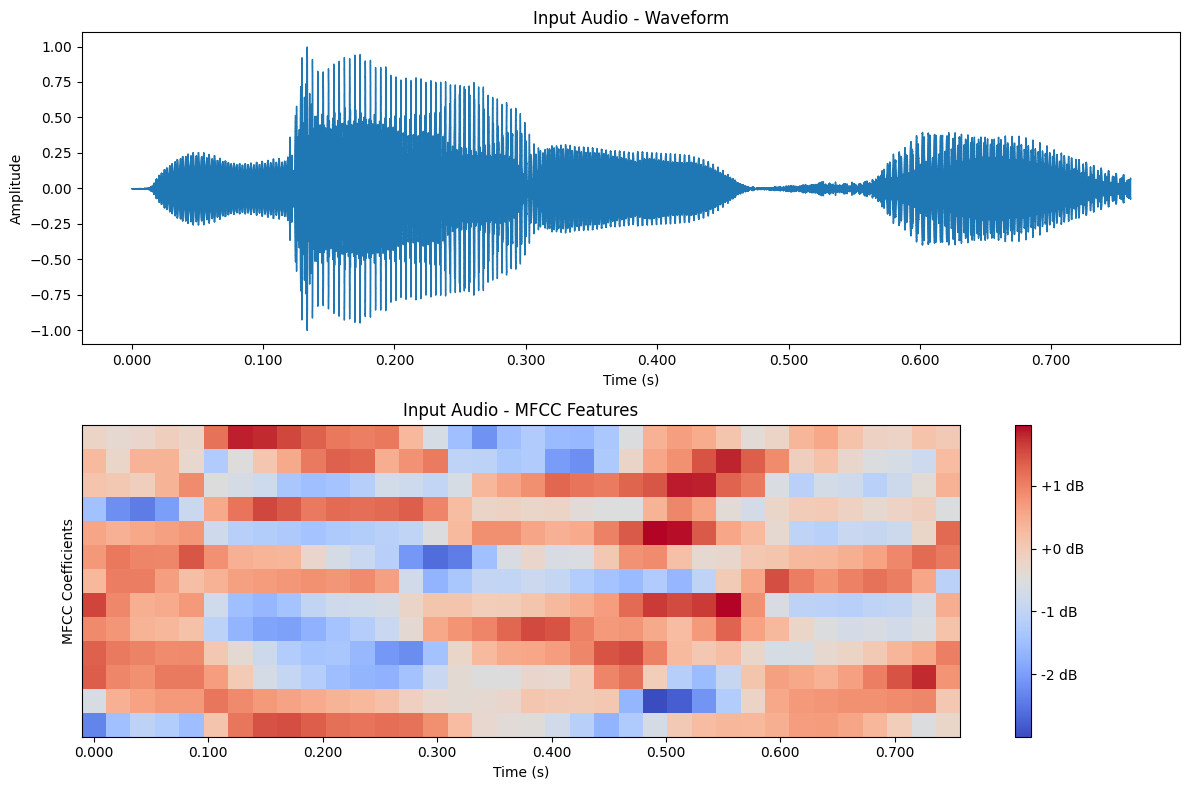

📊 MFCC shape: (36, 13)

✅ Workflow completed successfully!


In [19]:
def complete_workflow_example():
    """
    Complete workflow example for speech recognition system
    """
    print("🚀 Complete Speech Recognition Workflow")
    print("=" * 50)

    # Step 1: Check if audio directory exists
    if not os.path.exists('audio'):
        print("📁 Creating 'audio' directory...")
        os.makedirs('audio')
        print("⚠️ Please add your audio files to the 'audio' directory")
        print("   Required files for Bangla words:")
        print("   - ashun_1.wav, ashun_2.wav")
        print("   - ha_1.wav, ha_2.wav")
        print("   - na_1.wav, na_2.wav")
        print("   - biday_1.wav, biday_2.wav")
        print("   - bondho_1.wav, bondho_2.wav")
        print("   - input.wav (for testing)")
        return

    # Step 2: Define template files
    template_files = {
        'ashun': ['audio/ashun_1.wav', 'audio/ashun_2.wav'],
        'ha': ['audio/ha_1.wav', 'audio/ha_2.wav'],
        'na': ['audio/na_1.wav', 'audio/na_2.wav'],
        'biday': ['audio/biday_1.wav', 'audio/biday_2.wav'],
        'bondho': ['audio/bondho_1.wav', 'audio/bondho_2.wav']
    }

    # Check if template files exist
    missing_files = []
    for word, files in template_files.items():
        for file in files:
            if not os.path.exists(file):
                missing_files.append(file)

    if missing_files:
        print("❌ Missing audio files:")
        for file in missing_files:
            print(f"   - {file}")
        print("\n⚠️ Please add the missing files and run again.")
        return

    try:
        # Step 3: Create templates
        print("\n📚 Step 1: Creating templates...")
        templates, words = create_templates(template_files)

        # Step 4: Test recognition
        if os.path.exists('audio/input.wav'):
            print("\n🎤 Step 2: Testing recognition...")
            recognized_word, distance, all_distances = recognize_speech(
                'audio/input.wav', templates, words
            )

            # Step 5: Visualize results
            print("\n📊 Step 3: Visualizing results...")
            plot_mfcc_features('audio/input.wav', 'Input Audio')

        else:
            print("\n⚠️ 'audio/input.wav' not found. Skipping recognition test.")
            print("   Add an input audio file to test recognition.")

        print("\n✅ Workflow completed successfully!")

    except Exception as e:
        print(f"❌ Error in workflow: {str(e)}")


# Run the complete workflow example
complete_workflow_example()

## 10. System Configuration and Utilities
Configuration parameters and utility functions

In [12]:
# System configuration
class SpeechRecognitionConfig:
    """
    Configuration class for speech recognition system
    """
    # MFCC parameters
    N_MFCC = 13
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MELS = 40

    # Audio preprocessing parameters
    FRAME_LENGTH = 0.02  # 20ms
    ENERGY_THRESHOLD = 0.01

    # Recognition parameters
    RECOGNITION_THRESHOLD = 100.0

    # File paths
    AUDIO_DIR = 'audio'
    TEMPLATES_FILE = 'templates.pkl'

    @classmethod
    def print_config(cls):
        """Print current configuration"""
        print("⚙️ System Configuration:")
        print(f"   MFCC coefficients: {cls.N_MFCC}")
        print(f"   FFT size: {cls.N_FFT}")
        print(f"   Hop length: {cls.HOP_LENGTH}")
        print(f"   Mel filters: {cls.N_MELS}")
        print(f"   Recognition threshold: {cls.RECOGNITION_THRESHOLD}")
        print(f"   Audio directory: {cls.AUDIO_DIR}")
        print(f"   Templates file: {cls.TEMPLATES_FILE}")


def system_info():
    """
    Display system information and requirements
    """
    print("🔧 Speech Recognition System Information")
    print("=" * 45)
    print("📋 Features:")
    print("   ✅ MFCC feature extraction using librosa")
    print("   ✅ DTW pattern matching with dynamic programming")
    print("   ✅ Audio preprocessing (silence trimming, normalization)")
    print("   ✅ Template-based word recognition")
    print("   ✅ Bilingual support (Bangla & English)")
    print("   ✅ Batch processing capability")
    print("   ✅ Visualization and analysis tools")

    print("\n📦 Dependencies:")
    dependencies = [
        'librosa', 'numpy', 'scipy', 'matplotlib',
        'dtw-python', 'soundfile', 'pickle'
    ]
    for dep in dependencies:
        print(f"   - {dep}")

    print("\n🎯 Supported Audio Formats:")
    print("   - WAV (recommended)")
    print("   - MP3, FLAC, OGG (via librosa)")

    print("\n📁 Directory Structure:")
    print("   project/")
    print("   ├── speech-recognition-mfcc-dtw.ipynb")
    print("   ├── audio/")
    print("   │   ├── ashun_1.wav, ashun_2.wav")
    print("   │   ├── ha_1.wav, ha_2.wav")
    print("   │   ├── na_1.wav, na_2.wav")
    print("   │   ├── biday_1.wav, biday_2.wav")
    print("   │   ├── bondho_1.wav, bondho_2.wav")
    print("   │   └── input.wav")
    print("   └── templates.pkl (generated)")


# Display system information
system_info()
print("\n")
SpeechRecognitionConfig.print_config()

🔧 Speech Recognition System Information
📋 Features:
   ✅ MFCC feature extraction using librosa
   ✅ DTW pattern matching with dynamic programming
   ✅ Audio preprocessing (silence trimming, normalization)
   ✅ Template-based word recognition
   ✅ Bilingual support (Bangla & English)
   ✅ Batch processing capability
   ✅ Visualization and analysis tools

📦 Dependencies:
   - librosa
   - numpy
   - scipy
   - matplotlib
   - dtw-python
   - soundfile
   - pickle

🎯 Supported Audio Formats:
   - WAV (recommended)
   - MP3, FLAC, OGG (via librosa)

📁 Directory Structure:
   project/
   ├── speech-recognition-mfcc-dtw.ipynb
   ├── audio/
   │   ├── ashun_1.wav, ashun_2.wav
   │   ├── ha_1.wav, ha_2.wav
   │   ├── na_1.wav, na_2.wav
   │   ├── biday_1.wav, biday_2.wav
   │   ├── bondho_1.wav, bondho_2.wav
   │   └── input.wav
   └── templates.pkl (generated)


⚙️ System Configuration:
   MFCC coefficients: 13
   FFT size: 2048
   Hop length: 512
   Mel filters: 40
   Recognition threshold: 

## 11. Quick Start Guide
Instructions for immediate usage

In [13]:
def quick_start_guide():
    """
    Display quick start guide for users
    """
    print("🚀 Quick Start Guide")
    print("=" * 30)

    print("\n📁 Step 1: Prepare Audio Files")
    print("   1. Create an 'audio' folder in your project directory")
    print("   2. Add training audio files for each word:")
    print("      - ashun_1.wav, ashun_2.wav (বসুন)")
    print("      - ha_1.wav, ha_2.wav (হ্যাঁ)")
    print("      - na_1.wav, na_2.wav (না)")
    print("      - biday_1.wav, biday_2.wav (বিদায়)")
    print("      - bondho_1.wav, bondho_2.wav (বন্ধ)")
    print("   3. Add input.wav for testing")

    print("\n🔧 Step 2: Create Templates")
    print("   Run the template creation code in cell 7")

    print("\n🎤 Step 3: Test Recognition")
    print("   Run the recognition code in cell 7 with your input audio")

    print("\n📊 Step 4: Analyze Results")
    print("   Use visualization tools to analyze MFCC features and results")

    print("\n⚡ One-Click Execution:")
    print("   Run all cells in sequence (Ctrl+Shift+Enter or 'Run All')")

    print("\n💡 Tips:")
    print("   - Use high-quality, clear audio recordings")
    print("   - Keep consistent recording conditions")
    print("   - Adjust recognition threshold based on your data")
    print("   - Add more template samples for better accuracy")

# Display quick start guide
quick_start_guide()

print("\n" + "=" * 60)
print("✅ SPEECH RECOGNITION SYSTEM READY!")
print("🎯 Execute all cells to run the complete system")
print("📚 Refer to individual cells for specific functionality")
print("🔧 Modify configuration in SpeechRecognitionConfig class")
print("=" * 60)

🚀 Quick Start Guide

📁 Step 1: Prepare Audio Files
   1. Create an 'audio' folder in your project directory
   2. Add training audio files for each word:
      - ashun_1.wav, ashun_2.wav (বসুন)
      - ha_1.wav, ha_2.wav (হ্যাঁ)
      - na_1.wav, na_2.wav (না)
      - biday_1.wav, biday_2.wav (বিদায়)
      - bondho_1.wav, bondho_2.wav (বন্ধ)
   3. Add input.wav for testing

🔧 Step 2: Create Templates
   Run the template creation code in cell 7

🎤 Step 3: Test Recognition
   Run the recognition code in cell 7 with your input audio

📊 Step 4: Analyze Results
   Use visualization tools to analyze MFCC features and results

⚡ One-Click Execution:
   Run all cells in sequence (Ctrl+Shift+Enter or 'Run All')

💡 Tips:
   - Use high-quality, clear audio recordings
   - Keep consistent recording conditions
   - Adjust recognition threshold based on your data
   - Add more template samples for better accuracy

✅ SPEECH RECOGNITION SYSTEM READY!
🎯 Execute all cells to run the complete system
📚 R